In [28]:

"""

NOTE:
I ran the code on Googel Cloud Platform and when you run it on your machine, if any intendation error occurs, pls 
rectify as copy pasting the code form cloud to local machine raised intendation error and moreover I added the comments later.
Thanks


"""
#import libraries needed
import numpy as np
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
import sys
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Bidirectional,Dense,Dropout,LSTM,BatchNormalization
from keras.utils import np_utils
import os
from keras.callbacks import CSVLogger
import re
from keras.callbacks import LambdaCallback
import random
import keras.backend as K
import pickle
#regex = re.compile('[@_\+\:\;\*!#$%^&*()<>?/\|}{~:¹⁷⁵⁹⁻★²→₁\ufeff\[\]]')


#set of allowed characters. Rest all filtered out using regular expressions in python
#only alphabets,numbers,comma,exclamation,hyphen,single quote,double quote,new line,tab space allowed.
regex=re.compile('[^a-zA-Z0-9.\?\!\-\'\"\n\t\ ,]')
#book is the folder that holds all 5 books that are used for training. the variable contains list of all books 
filename = os.listdir('book')
#sample of all allowed characters. Sometimes the training data might not have some allowed characters. So manually 
#add only one sample for the sake of representation.
data="1234567890qwertyuiopasdfghjklzxcvbnm.,\?'\"\!\-\n\t"
#iterate through every book
for file in filename:
        #print book name
  print(file)
    #sometimes, jupter notebook stores a checkpoint inside the folder. To avoid reading it, check if the 1st character is a .
    #If the first character is a . then it is a checkpointed file saved by jupyter. So skip it
  if(file[0]=='.'):
    continue
    #read the book contents.
  txt = open('book/'+str(file), 'r', encoding='utf-8').read()
    #read each character
  for line in txt:
    #if character is in allowed set of characters, add it to training data
    if (regex.search(line)==None):
      data += line
  #data+=txt
  print("Length:",len(txt))
print("Total length:",len(data))

#convert uppercase characters if any to lower case
data = data.lower()
#assign timestamp to be 50 
input_size = 50
#get the list of unique characters
chars = (list(set(data)))
#dictionary to store character to integer mapping 
d={}
#dictionary to store integer to character reverse mapping
revd={}
#for each unique character in dataset assign a integer
for i,c in enumerate(chars):
  d[c]=i
  revd[i]=c

print("Unique characters:",chars)
print("Total unique chars:",len(chars))
#training data
x = list()
#label data
y = list()
#prepare training data
for i in range(0, len(data) - input_size, 3):
        #characters from current index i to i+index size(timestamp)-1 are considered as input.
	_ = data[i:i + input_size]
    #copy the required contents to a temporary list
	tmp=[]
	for c in _:
		tmp.append(c)
        #append the temporary list to training data
	x.append(tmp)
    #the  character in position of current position+ timestamp is the one to be predicted. So add it to label.
	__ = data[i + input_size]
	y.append(__)



    #since we onehot encode training and test data, we have an additional dimension of size=vocabulary size.
#Since one hot vector encoding is sparse array with only one position being 1 and rest all 0, initialise to be 0
X = np.zeros((len(x), input_size, len(chars)), dtype=np.bool)
Y = np.zeros((len(x), len(chars)), dtype=np.bool)
#for each training data

for i, s in enumerate(x):
        #for each character in training data, i is the index of current training data and s in the sentence 
  for ts, c in enumerate(s):
    #for each character in the current training data, c is the character and ts is the timestep of that character
    #do one hot encoding of each character in current training data
    X[i, ts, d[c]] = 1
    #Do one hot encoding of label character
  Y[i, d[y[i]]] = 1

#define model

model = Sequential()
#add LSTM layer. 

model.add((LSTM(128, input_shape=(input_size, len(chars)), return_sequences=True)))
#Dropout to avoid overfitting and to act like a regularizer

model.add(Dropout(0.4))
#Batch normalisation causes early convergence and reduces training epochs needed for convergence

model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros'))


model.add((LSTM(256, input_shape=(input_size, len(chars)), return_sequences=False)))
model.add(Dropout(0.4))
#Output layer does softmax of probabilities of each character

model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros'))


model.add((Dense(len(chars), activation='softmax')))
#Adam optimiser is best suited for deep learning

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy','mse'])
#add checkpoint to save weights after each epoch.Saves only if loss has improved

model_check_point = ModelCheckpoint("_book/weight-{epoch:02d}.hdf5", monitor='loss', verbose=1, save_best_only=True, mode='auto')
#reduce_lr_on_plateau=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,verbose=1)
#store metrics like training and validation loss,accuracy and mse in a csv file

csv_logger = CSVLogger("_book/log.csv", append=True, separator=';')

"""
y = np_utils.to_categorical(y)

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
x = min_max_scaler.fit_transform(x)

x = np.reshape(x, (len(x), input_size, 1))
print(x.shape)
print(y.shape)
"""


all around the moon.txt
Length: 605847
the princess of mars.txt
Length: 391574
interstellar.txt
Length: 501646
the story of nuclear energy.txt
Length: 92974
invisible man.txt
Length: 292669
Total length: 1873069
Unique characters: ['n', 'j', 'f', '6', '2', 'k', '\\', '?', 'x', 'h', "'", 'w', '0', '4', 'a', '.', 'y', '3', 'i', 'd', 'r', '\t', '1', 'c', ',', '!', 'o', 'g', '7', '\n', 'q', '"', ' ', 'p', '9', 'b', '5', 'v', 'l', 'm', 'z', 'e', '8', 'u', 's', 't', '-']
Total unique chars: 47


'\ny = np_utils.to_categorical(y)\n\nfrom sklearn.preprocessing import MinMaxScaler\nmin_max_scaler = MinMaxScaler()\nx = min_max_scaler.fit_transform(x)\n\nx = np.reshape(x, (len(x), input_size, 1))\nprint(x.shape)\nprint(y.shape)\n'

In [29]:
#callback function called after each epoch's end. 

def on_epoch_end(epoch,logs={}):
        #select a random starting point for seed sentence
  idx = random.randint(0, len(data) - input_size - 2)
    #genrate output with different diversity values

  for div in [0.3,0.6,0.9,1.2,1.5]:
    print('\nDiversity=', div)
        #seed sentence 

    seed=data[idx:idx+input_size]
    print('Seed sentence=',seed)
        #predict next 300 characters 
    for _ in range(300):
                #one hot encode seed sentence
      ip=np.zeros((1, input_size, len(chars)),dtype='float64')
      for i,c in enumerate(seed):
        ip[0,i,d[c]]=1.0
                #predict next character
      op=model.predict(ip).flatten()
        #convert predicted char to numpy array
      op=np.array(op,dtype='float64')
            #use diversity for randomness
      op=np.exp(np.log(op)/div)
      op=op/np.sum(op)
                #use binomial distribution to predict the randomised predicted character
      pred_char=revd[np.argmax(np.random.multinomial(1,op,1))]
            #append the predicted character and discard the 1st character for next prediction
      seed=seed[1:]+pred_char
      sys.stdout.write(pred_char)
      sys.stdout.flush()
    #store optimiser weights
  symbolic_weights = getattr(model.optimizer, 'weights')
  weight_values = K.batch_get_value(symbolic_weights)
  with open('_book/optimizer.pkl', 'wb') as f:
    pickle.dump(weight_values, f)
cb=LambdaCallback(on_epoch_end=on_epoch_end)

In [31]:
#train model.
hist=model.fit(X,Y, epochs=30, validation_split=0.1,batch_size=128, callbacks=[csv_logger,model_check_point,cb])

Train on 561906 samples, validate on 62434 samples
Epoch 1/30
561906/561906 [==============================] - 700s 1ms/step - loss: 2.1790 - accuracy: 0.3725 - mse: 0.0162 - val_loss: 1.8218 - val_accuracy: 0.4544 - val_mse: 0.0145

Epoch 00001: loss improved from inf to 2.17904, saving model to _book/weight-01.hdf5

Diversity= 0.3
Seed sentence= osynthesis chloroplasts in
plants24 chapter 11 use
 of the see the captain the sect of the can and for the sing of the stars of the can a was the same the project gutenberg-tm the marnians of the projectile of the mole and and so said in the many same of the was and the bear the spice of the moon and in the first with was the and the more of the con
Diversity= 0.6
Seed sentence= osynthesis chloroplasts in
plants24 chapter 11 use
 large the moon and by we that on the starth. when to the comenter the sides and on the great interstellar. by afters the form in the ats project gule belest comped so far energy began the bering with work gues some i

In [32]:
#conda install tornado==4.5.3
model.save('final_weight.h5')
import pickle
import pandas as pd
# convert the hist.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(hist.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

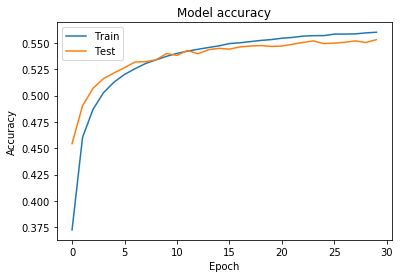

In [33]:
#plot metrics data

import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



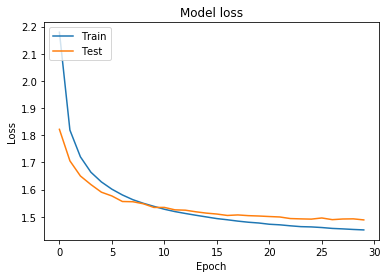

In [34]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

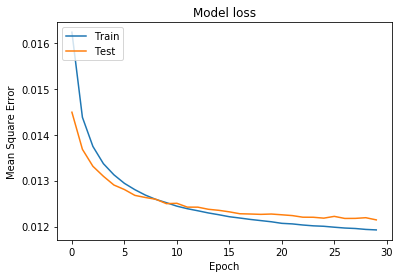

In [35]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('Model loss')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()